# Tелекоммуникации

**Кратко о задаче:**

Оператор связи хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи.

Чтобы заранее находить таких пользователей, сервису нужна модель, которая будет предсказывать, разорвёт ли абонент договор.

Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах.

***Задача*** — обучить на этих данных модель для прогноза оттока клиентов.

**Требование** — метрика ROC-AUC для финальной модели должна быть выше показателя в 0,85.

***План работы:***
* Загрузить данные и выполнить их первичный осмотр.
* Выполнить исследовательский анализ каждого датафрейма и при необходимости выполнить предобработку.
* Объединить выбранные признаки в один датафрейм и выделить целевой признак.
* Выполнить подготовку данных для обучения модели.
* Обучить модели.
* Выберать лучшую модель и проверьте её качество на тестовой выборке.

**Описание данных**

Данные состоят из нескольких файлов, полученных из разных источников:

`contract_new.csv` — информация о договоре;

`personal_new.csv` — персональные данные клиента;

`internet_new.csv` — информация об интернет-услугах;

`phone_new.csv` — информация об услугах телефонии.

Файл **contract_new.csv**

 - `customerID` — идентификатор абонента;
 - `BeginDate` — дата начала действия договора;
 - `EndDate` — дата окончания действия договора;
 - `Type` — тип оплаты: раз в год-два или ежемесячно;
 - `PaperlessBilling` — электронный расчётный лист;
 - `PaymentMethod` — тип платежа;
 - `MonthlyCharges` — расходы за месяц;
 - `TotalCharges` — общие расходы абонента.

Файл **personal_new.csv**

 - `customerID` — идентификатор пользователя;
 - `gender` — пол;
 - `SeniorCitizen` — является ли абонент пенсионером;
 - `Partner` — есть ли у абонента супруг или супруга;
 - `Dependents` — есть ли у абонента дети.

Файл **internet_new.csv**

 - `customerID` — идентификатор пользователя;
 - `InternetService` — тип подключения;
 - `OnlineSecurity` — блокировка опасных сайтов;
 - `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
 - `DeviceProtection` — антивирус;
 - `TechSupport` — выделенная линия технической поддержки;
 - `StreamingTV` — стриминговое телевидение;
 - `StreamingMovies` — каталог фильмов.

Файл **phone_new.csv**

 - `customerID` — идентификатор пользователя;
 - `MultipleLines` — подключение телефона к нескольким линиям одновременно.

## Выгрузка данных и импорт необходимых библиотек

In [2]:
try:
    import phik
    from phik.report import plot_correlation_matrix
    print("Отработал первый путь (try)")
except:
    !pip install -q phik
    import phik
    from phik.report import plot_correlation_matrix
    print("Отработал второй путь (except)")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 6.0 MB/s eta 0:00:00
Отработал второй путь (except)


In [3]:
try:
    import optuna
    from optuna.samplers import TPESampler
except:
    !pip install -q optuna
    import optuna
    from optuna.samplers import TPESampler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.9 MB/s eta 0:00:00


In [4]:
try:
    import shap
except:
    !pip install -q shap
    import shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 6.7 MB/s eta 0:00:00


In [5]:
try:
    from catboost import CatBoostClassifier
except:
    !pip install -q catboost
    from catboost import CatBoostClassifier

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.4 MB/s eta 0:00:00


In [6]:
try:
    from warnings import simplefilter
    simplefilter(action='ignore', category=FutureWarning)
except:
    !pip install -q warnings
    from warnings import simplefilter
    simplefilter(action='ignore', category=FutureWarning)

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b>
<br/>Добавил библиотеку, чтоб убрать постоюнные предупреждения при поиске гиперпараметров.
</div>

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import os

In [8]:
pth1 = ''
pth2 = '/datasets/'

if os.path.exists(pth1 + 'contract_new.csv'):
    contract_df = pd.read_csv(pth1 + 'contract_new.csv')
elif os.path.exists(pth2 + 'contract_new.csv'):
    contract_df = pd.read_csv(pth2 + 'contract_new.csv')
else:
    print('Something is wrong with contract_new.csv')

if os.path.exists(pth1 + 'internet_new.csv'):
    internet_df = pd.read_csv(pth1 + 'internet_new.csv')
elif os.path.exists(pth2 + 'internet_new.csv'):
    internet_df = pd.read_csv(pth2 + 'internet_new.csv')
else:
    print('Something is wrong with internet_new.csv')

if os.path.exists(pth1 + 'personal_new.csv'):
    personal_df = pd.read_csv(pth1 + 'personal_new.csv')
elif os.path.exists(pth2 + 'personal_new.csv'):
    personal_df = pd.read_csv(pth2 + 'personal_new.csv')
else:
    print('Something is wrong with personal_new.csv')

if os.path.exists(pth1 + 'phone_new.csv'):
    phone_df = pd.read_csv(pth1 + 'phone_new.csv')
elif os.path.exists(pth2 + 'phone_new.csv'):
    phone_df = pd.read_csv(pth2 + 'phone_new.csv')
else:
    print('Something is wrong with phone_new.csv')

Зададим константы

In [9]:
RANDOM_STATE = 61123
TEST_SIZE = 0.25

## Исследовательский анализ датасетов

Напишим функции для визуализации данных в датафреймах

In [10]:
# Функция для автоматизации круговых диаграм (для категориальных признаков)
def pieplots(df, column):
    info = df[column].value_counts(ascending=True, dropna=False)
    # Массив для выделения самого большого сектора
    explode = np.zeros(len(info))
    explode[-1]=0.1
    # Создадим для subplots отображения легенды в виде таблицы
    fig, ax = plt.subplots(figsize=(6, 3))

    # Функция для создация обозначения процентных соотношений секторов
    def func(pct, allvals):
        absolute = int(np.round(pct/100.*np.sum(allvals)))
        return f"{pct:.1f}%"

    wedges, texts, autotexts = ax.pie(info, autopct=lambda pct: func(pct, info),
                                  explode=explode, textprops=dict(color="w"))
    # Создание легенды
    ax.legend(wedges, info.index,
              title='legend',
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))

    plt.setp(autotexts, size=8, weight="bold")
    ax.set_title(column)

    plt.show()

In [11]:
# Функция для визуализации категориальных и числовых признаков
def visualization(df, numerical, categorical):
  for i in range(len(numerical + categorical)):

    # Вывод категориального признака
    if (numerical + categorical)[i] in categorical:
        pieplots(df, (numerical + categorical)[i])

    # Вывод числового признака
    if (numerical + categorical)[i] in numerical:
        sns.histplot(df[(numerical + categorical)[i]], kde=True, bins=20).set_title((numerical + categorical)[i])
        plt.show()

Изучим певыую таблицу **contract_df**

In [12]:
contract_df.info()
print('\n')
contract_df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB




,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
934,4198-VFOEA,2019-02-01,No,One year,Yes,Mailed check,33.60,403.2
4853,0440-UEDAI,2015-09-01,No,One year,Yes,Credit card (automatic),94.45,5256.14
4262,5485-WUYWF,2019-11-01,No,Month-to-month,No,Bank transfer (automatic),66.40,199.2
5160,9840-EFJQB,2020-01-01,No,Month-to-month,No,Electronic check,74.35,74.35
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,


Данные содержат 7043 записи. Пропуски отсутствуют. Почти все данные хранятся в виде строк, кроме столбца `MonthlyCharges`. Признак `EndDate` можно перевести в формат datetime для более удобной отработки. Столбец `EndDate` содержит в себе данные и значения ***' No'***, следовательно часть контрактов анулированны, а часть нет, из этой информации модно выделить целевой признак об оттоке клиентов. Данные `PaperlessBilling` можно перевести в числовой или булевый тип данных, но стоит сначала изучить их распределение на диаграмме, а в дальнейшем воспользоваться кодированием признаков.

In [13]:
contract_df.loc[contract_df['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


`TotalCharges` - не имеет тип данных числовой следовательно следует изучить выбивающиеся значения в нём. При попытке преобразовать в тип данных *float* появляется предупреждение о наличии  пустых строк ' '. В таком случае общие расходы сложно предугадать, однако обратим внимание что у всех договоров одинаковая дата заключения контракта и она совпадает с актуальной датой о договорах - *1 февраля 2020 года*. Следовательно это новые клиенты и вероятно либо оплата с их стороны ещё не поступала, либо при записи/хранение/передаче данных произошла ошибка.

Лучше обратится к поставщику данных и уточнить, как происходит оплата при заключении контракта. В данном случае наиболее предпочтительно заменить пропуски на 0.

In [14]:
contract_df.loc[contract_df['BeginDate'] == '2020-02-01']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


In [15]:
contract_df.loc[contract_df['TotalCharges'] == ' ', 'TotalCharges'] = 0
contract_df['TotalCharges'] = contract_df['TotalCharges'].astype(float)
contract_df['BeginDate'] = pd.to_datetime(contract_df['BeginDate'], format='%Y-%m-%d')

print(contract_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB
None


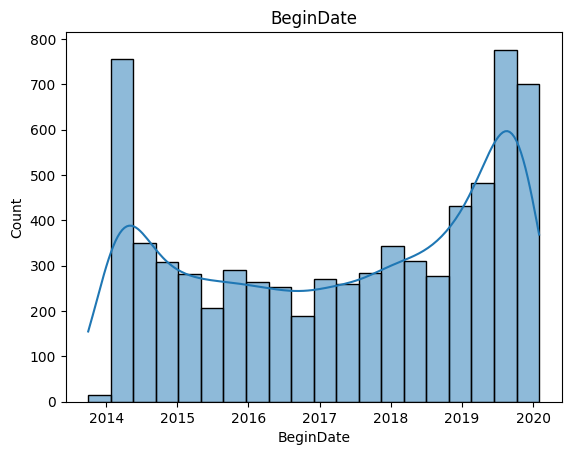

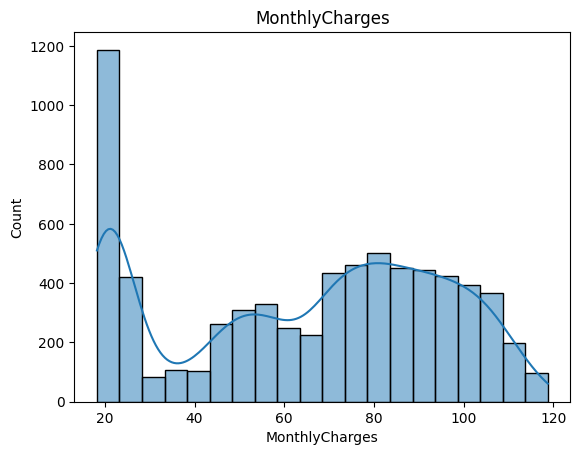

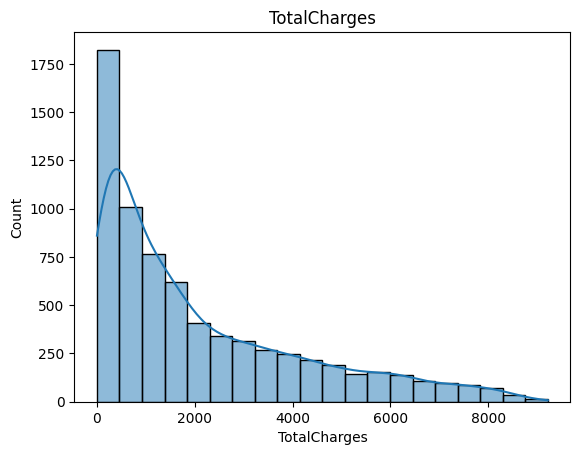

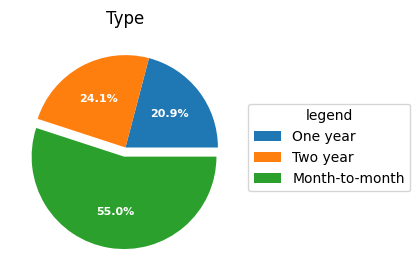

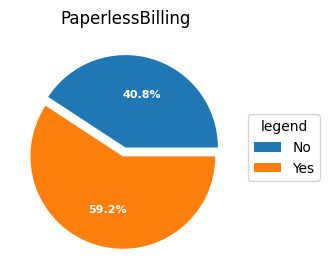

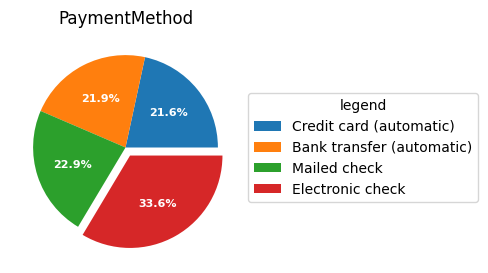

In [16]:
visualization(contract_df, ['BeginDate', 'MonthlyCharges', 'TotalCharges'], ['Type', 'PaperlessBilling', 'PaymentMethod'])

Обратим внимание, что распределение новых пользователей имеет два пика в 2014 году - ранний год в датасете и в 2019 год. Это может быть связанно с проводимыми рекламными компаниями или ситуацией на рынке предоставляемых услуг. Аномалий в распределение не замечено.

Распределение месячных расходов зависит от выбранных услуг и формы оплаты. Можно условно различить 3 группы. Вероятно из тех, кто пользуется интернет-услугами и стриминговыми сервисами.

Распределение общих расходов похоже на распределение Стьюдента или смещенное нормальное. Значение этой величины зависит от средних месячных расходов и длительности контракта. Чем выше значение тем меньше людей контрактов имеющих подходящую продолжительность при своём среднем расходе за месяц.

Из остальных данных можно выделить, что порядка 59% клиентов имеют электронный расчётный лист и 41% нет.

Наиболее популярна помесячная оплата и приблизительно одинаковое  число людей предпочитают платить за год и за два.

Треть клиентов оплачивают электронным чеком, тогда как остальные 3 вида оплаты примерно равноценно популярны и примерно 22% пользуются каждым из них.

In [17]:
internet_df.info()
print('\n')

internet_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB




,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Не все клиенты пользуются интернет-услугами, ьак как количество общих строк 5517, что меньше чем в общей таблице контрактов.
Пропусков  в данных нет.

Данные колонок `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`и `StreamingMovies` можно привести к числовому или булевому типу данных. Все столбцы являются категориальными признаками.

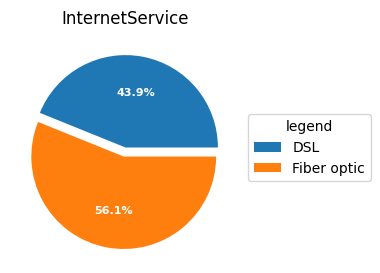

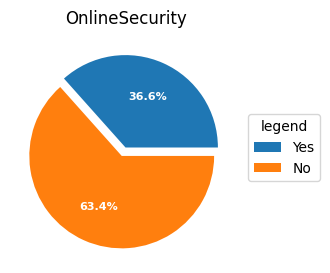

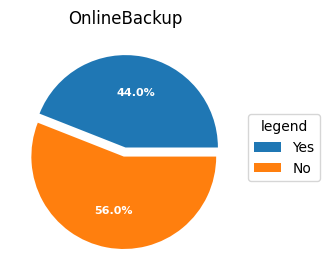

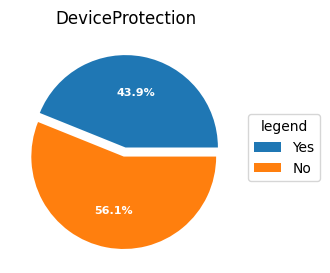

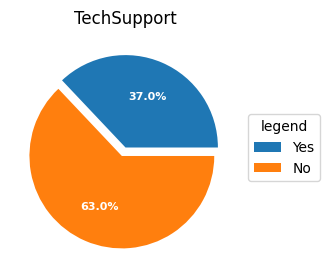

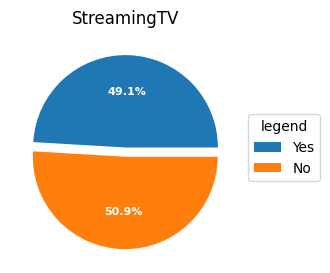

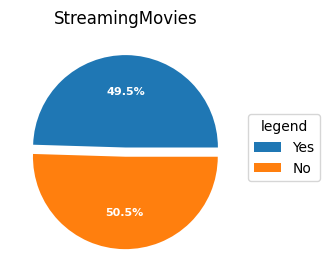

In [18]:
visualization(internet_df, [], ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'])

Чуть больше пользователей предпочитают оптоволоконный тип подключения.

Почти две трети пользователей не пользуются услугой блокировки опасных сайтов.

Чуть больше половины пользователей не использует облачное хранилище файлов для резервного копирования данных.

Примерно столькоже *(56%)* не пользуются антивирусом.

63% людей не подключают услугу выделенной линии технической поддержки.

Почти половина контрактов включают в себя услуги стримингого телевидения и каталог фильмов.

In [19]:
personal_df.info()
print('\n')

personal_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB




,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


В таблице нет пропусков и одинаковое значение строк с данными о контрактах.

Все признаки категориальные и бинарные.

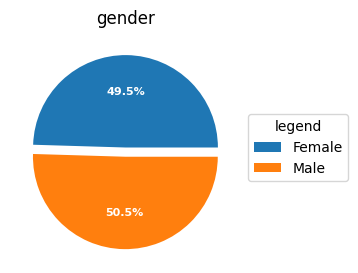

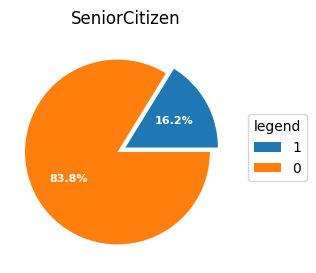

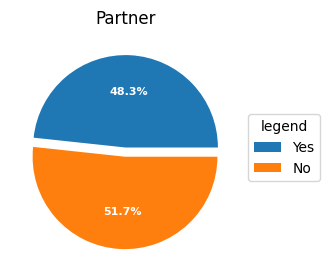

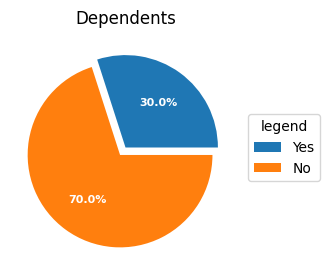

In [20]:
visualization(personal_df, [], ['gender', 'SeniorCitizen', 'Partner', 'Dependents'])

Количество клиентов мужчин почти равное.

Лишь 16,2% являются пенсионерами.

Чуть более у половины нет супруги или супруга

У 70% нет детей.

In [21]:
phone_df.info()
phone_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


В таблице нет пропусков но не все пользователи пользуются подключением телефона к нескольким линиям одновременно.

Признак категориальный и бинарный.

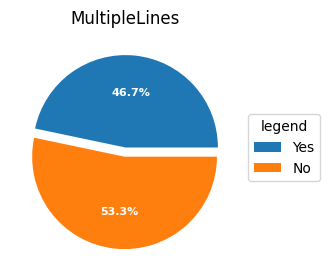

In [22]:
visualization(phone_df, [], ['MultipleLines'])

Лишь 46,7% из представленных имеют эту услугу. В общем дата сете будет меньше.

## Объединение датасета и подготовка признаков

In [23]:
full_df = contract_df.merge(right=personal_df, how='outer', on='customerID')
full_df = full_df.merge(right=internet_df, how='outer', on='customerID')
full_df = full_df.merge(right=phone_df, how='outer', on='customerID')

full_df.info()
full_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup      5517 n

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


Поскольку не все датасеты содержат одинаковую длину, то появившиеся пропуски после объединения необходимо заполнить.

Предположим, что пропуски обусловлены тем, что пользователи с пропусками никогда не пользовались и им не предлагали данную услугу.

Но при возможности лучше обратиться к поставщику данных. Ведь таблицы могли быть частично повреждены.

In [24]:
full_df.fillna('No', inplace=True)
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup      7043 n

Учитывая описанное ранее создадим столбец с целевым признаком. И составим портрет ушедших клиентов.

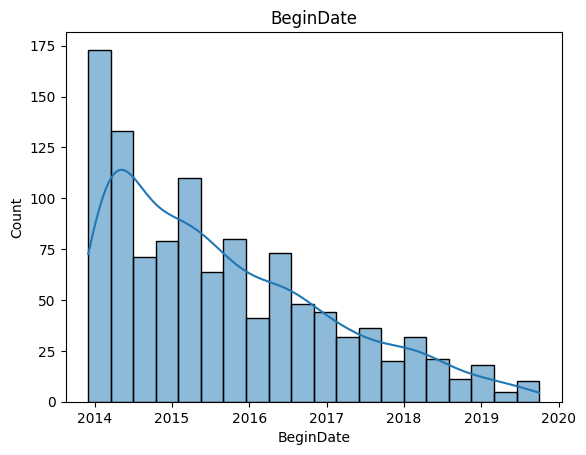

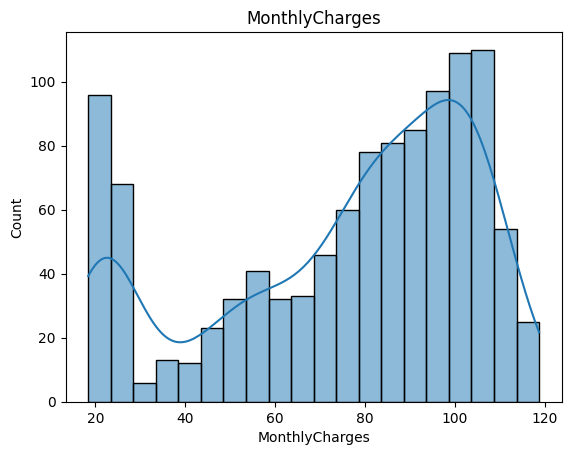

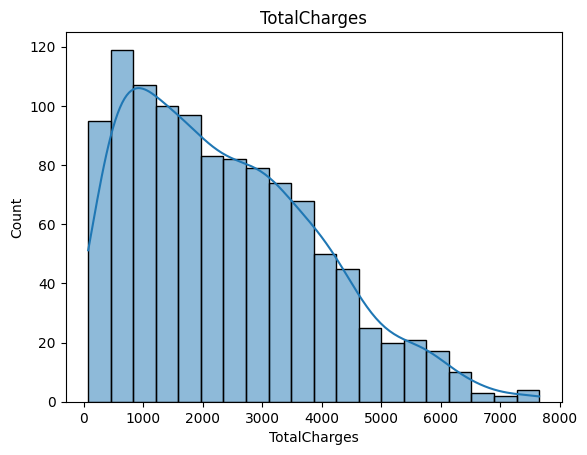

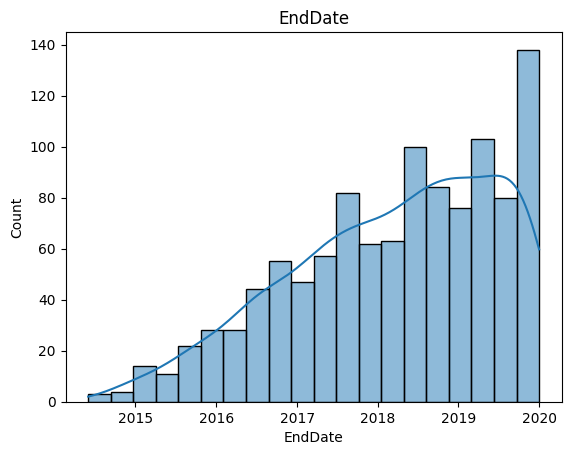

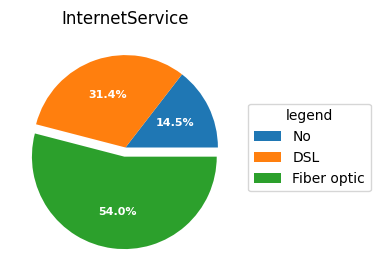

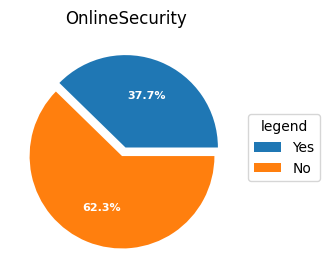

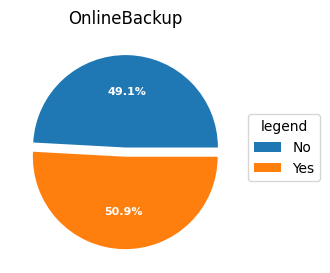

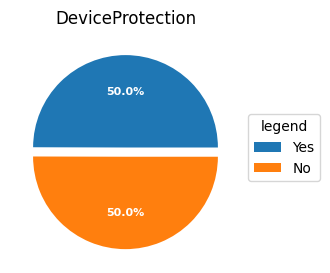

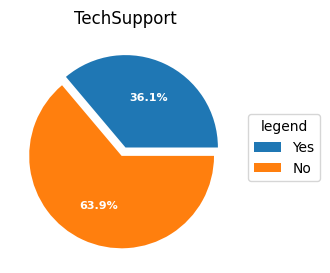

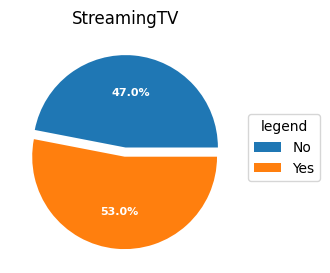

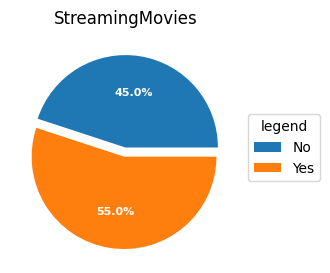

In [25]:
full_df['target'] = (full_df['EndDate'] != 'No').astype(int)
# Заменим значения No на актуальную дату, что бы в будущем добавить новый признак.
full_df.loc[full_df['EndDate'] == 'No', 'EndDate'] = '2020-02-01'
full_df['EndDate'] = pd.to_datetime(full_df['EndDate'], format='%Y-%m-%d')

visualization(full_df[full_df['target'] == 1], ['BeginDate', 'MonthlyCharges', 'TotalCharges', 'EndDate'],
              ['InternetService', 'OnlineSecurity',
               'OnlineBackup', 'DeviceProtection',
               'TechSupport', 'StreamingTV',
               'StreamingMovies'])

Количество разорванных контрактов больше среди тех дольше пользуется услугами компании в "сегменте постоянных клиентов".

На графике ежемесячных платежей для ушедших клиентов видны два пика в области 20 и 100.

по графику суммарных платежей видно, что распределение в целом похоже на общее по полным данным. Однако вданном случае оно более выпуклое в зоне тех кто потратил от 2 до 4 тысяч.

С 2015 года происходит рост числа ушедших клиентов.

85,5% пользовались интернет-услугами. 54% ушедших выбирали оптоволоконное подключение.

Большинство *(62-63%)* не пользовалось услугами блокировки а опасных сайтов и выделенной линей тех. поддержки.

Ровно половина ушедших использовала антивирус и облачное хранилище.

Так же чуть больше половины пользуется стриминговым сервисом и библиотекой фильмов.

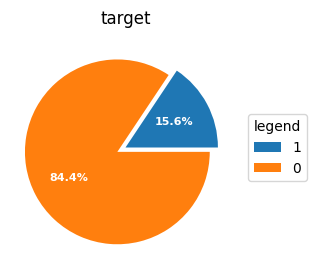

In [26]:
visualization(full_df, [], ['target'])

**На первый взгляд очевиден дисбаланс классов**

Учтём это создавая модели.

Так как целевой признак мы получили из двух других, то воизбежание утечки стоит удалить эти признаки.

Но поскольку помимо утечки они несут важную для предсказания информацию, попробуем её выделить в отдельный новый признак `duration` - длительность контракта

`customerID` - это столбец уникальных значений, этому отнесём его в индекс, чтобы так же избежать утечки.

In [27]:
full_df['duration'] = (full_df['EndDate'] - full_df['BeginDate']).dt.days
full_df.index = full_df['customerID'].values
full_df.drop(axis=1, columns=['customerID', 'BeginDate', 'EndDate'], inplace=True)

full_df.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,duration
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,0,31
5575-GNVDE,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1036
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0,123
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,0,1371
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,0,153


## Построение модели

Сразу разобъём данные на тестовую и обучающую выборки и будем проводить анализ и обработку только на обучающей.

In [28]:
train, test = train_test_split(full_df, test_size=TEST_SIZE, random_state=RANDOM_STATE)

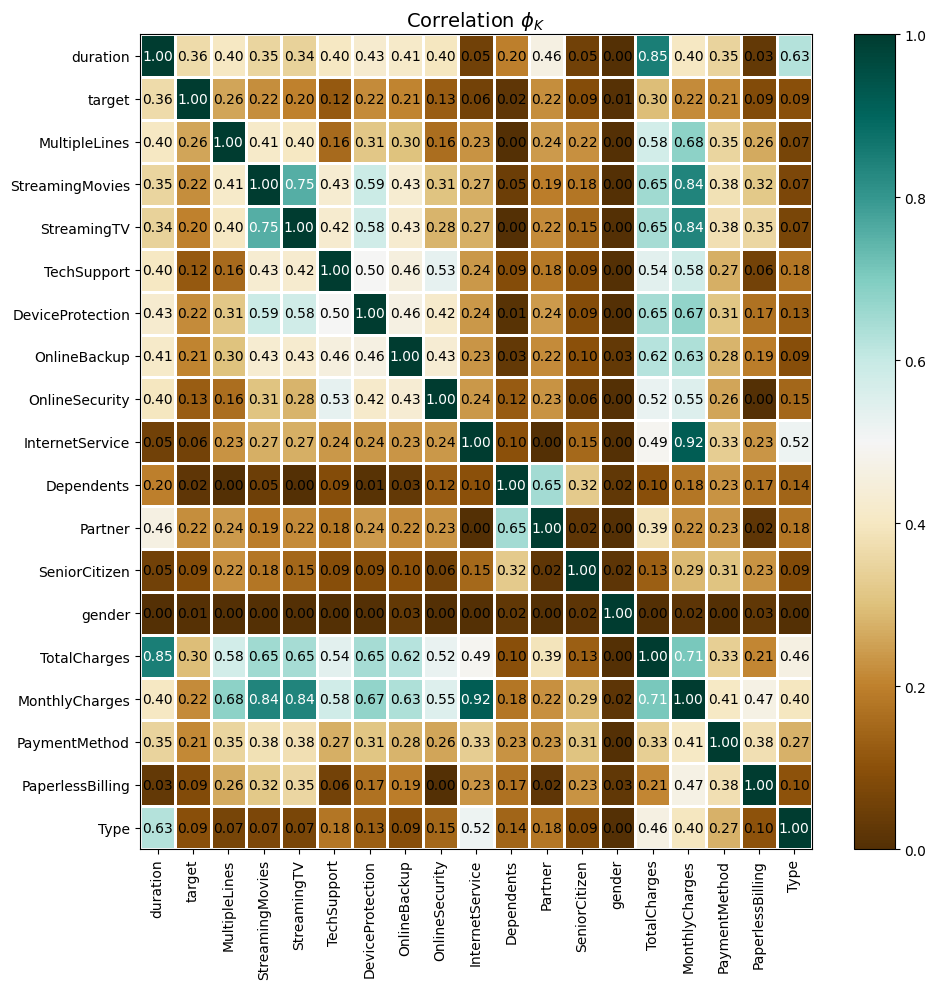

In [29]:
corr_matrix = train.phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges', 'duration'])

plot_correlation_matrix(corr_matrix.values, x_labels=corr_matrix.columns, y_labels=corr_matrix.index,
                        title='Correlation $\phi_K$', vmin=0, vmax=1, color_map='BrBG', figsize=(10, 10))

Среди признаков можно увидеть сильную корреляцию между месячными тратами и типом подключения. Можно исключить один из этих признаков, однако мы не видим большой корреляции с целевым признаком, поэтому рекоммендуется их пока оставить и сделать вывод что один тип подключения сильно дороже другого.

Тоже самое касается услуг стриминговых сервисов. Их подключение влияет на ежемесечный платёж и общую сумму трат.

Наибольшую корреляцию с целевым признаком можно увидеть у длительности, суммарного расхода и подключения телефона к нескольким линиям одновременно. Но коэффициент корреляции не превышает 0,36 следовательно утечки среди признаков нет.

Наименьшую корреляцию целевой признак имеет с полом, *коэф. корреляции 0,01*.

In [30]:
features_train = train.drop(axis=1, columns='target')
target_train = train.target

features_test = test.drop(axis=1, columns='target')
target_test = test.target

### Создание модели

Составим списки категореальных признаков и числовых

In [31]:
cat_columns = ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender',
               'SeniorCitizen', 'Partner', 'InternetService', 'Dependents',
               'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
               'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']
num_columns = ['MonthlyCharges', 'TotalCharges', 'duration']

Создадим пайплайны для предобработки признаков

In [32]:
ohe_piplene = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
])

ordinal_piplene = Pipeline([
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('simpleImputer_ohe', SimpleImputer(strategy='most_frequent'))
])

data_preprocessor = ColumnTransformer([
    ('cat', ordinal_piplene, cat_columns),
    ('num', 'passthrough', num_columns)
    ], remainder='passthrough')

Опишем финальный пайплай и словари моделей и их признаков

In [33]:
final_pipline = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

models__params = [
    #словарь для модели RandomForestClassifier
    {
        'models': [RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE, class_weight='balanced')],
        'models__n_estimators': range(200, 350, 50),
        'models__criterion':['gini', 'entropy'],
        'models__max_depth': range(3, 8, 1),
        'preprocessor__cat': [ordinal_piplene],
        'preprocessor__num': ['passthrough']
    },
    #словарь для модели LogisticRegression
    {
        'models': [LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1)],
        'models__penalty': ['l2', 'l1'],
        'models__solver': ['lbfgs', 'liblinear'],
        'preprocessor__cat': [ohe_piplene],
        'preprocessor__num': [StandardScaler(), 'passthrough']
    },
    #словарь для модели CatBoost
    {
        'models': [CatBoostClassifier(random_seed=RANDOM_STATE, verbose=0, auto_class_weights='Balanced')],
        'models__iterations': range(200, 400, 50),
        'models__depth': range(3, 8, 1),
        'models__loss_function': ['Logloss'],
        'preprocessor__cat': [ordinal_piplene],
        'preprocessor__num': ['passthrough']

    }
]

Используем RandomizedSearchCV для быстрого поиска лучшей модели. В дальнейшем выполним более долгую доработку но для единственной выбранной модели.

In [34]:
randomized_search = RandomizedSearchCV(
    final_pipline,
    models__params,
    n_iter=25,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    verbose=0,
    n_jobs=-1
)

In [35]:
randomized_search.fit(features_train, target_train)


5 fits failed out of a total of 125.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_s

In [36]:
print(f'Значение метрики ROC AUC лучшей модели: {randomized_search.best_score_}')

Значение метрики ROC AUC лучшей модели: 0.863125006642967


Выведем лучшие отобранные гипер параметры

In [37]:
randomized_search.best_params_

{'preprocessor__num': 'passthrough',
 'preprocessor__cat': Pipeline(steps=[('ordinal',
                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                 unknown_value=nan)),
                 ('simpleImputer_ohe', SimpleImputer(strategy='most_frequent'))]),
 'models__loss_function': 'Logloss',
 'models__iterations': 350,
 'models__depth': 5,
 'models': <catboost.core.CatBoostClassifier at 0x7b59c32479d0>}

### Инициализация модели

Используем библиотеку `OPTUNA` для поиска идеальных пораметров выбранной модели

In [38]:
def objective(trial):

    # Опишем модель и диапазоны гиперпараметров
    model = CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 100, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=False,
        random_seed=RANDOM_STATE
    )

    # Список для записи оценок при кроссвалидации
    roc_auc_list = []
    # Перебор гиперпараметров и обучение моделей
    X = data_preprocessor.fit_transform(features_train)
    y = target_train

    # Средняя оценка на кроссвалидации
    my_score = cross_val_score(model, X, y, scoring='roc_auc', cv=5).mean(keepdims=False)
    return my_score

In [39]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=RANDOM_STATE)
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
# Выполним перебор 100 моделей
study.optimize(objective, n_trials=100)

Отобразим гиперпараметры и значение метрики лучшей найденной модели.

In [40]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value:  0.909864863711765
  Params: 
    iterations: 833
    learning_rate: 0.07271013176011946
    depth: 4
    l2_leaf_reg: 0.013021062330903097
    bootstrap_type: Bayesian
    random_strength: 8.669692825219567e-05
    bagging_temperature: 0.38515312456752937
    od_type: Iter
    od_wait: 41


 ## Оценка модели

Выполним оценку финальной модели на тестовой выборке

In [41]:
X_train = pd.DataFrame(data_preprocessor.fit_transform(features_train), columns=features_train.columns)
y_train = target_train

X_test = pd.DataFrame(data_preprocessor.transform(features_test), columns=features_test.columns)
y_test = target_test

In [42]:
model_final = CatBoostClassifier(**trial.params, verbose=False)
model_final.fit(X_train, y_train)
y_pred = model_final.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred)

0.9390095248146487

**Результат:** метрика выше требуемого показателя в 0,85. Модель соответствует требованиям заказчика.

Проверим модель на влияние признаков и удостоверимся не допустили ли мы утечку целевого признака.

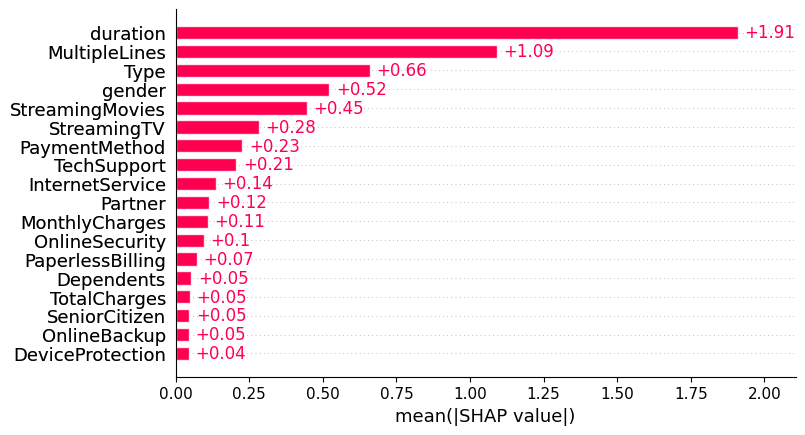

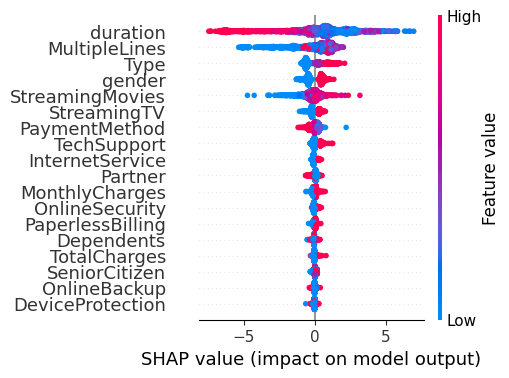

In [43]:
explainer = shap.TreeExplainer(model_final)
shap_values = explainer(X_test)

ax1 = plt.subplot(2,1,1)
ax1 = shap.plots.bar(shap_values,  max_display=18)

ax2 = plt.subplot(2,2,2)
ax2 = shap.plots.beeswarm(shap_values,  max_display=18)

Заметим что наибольшее влияние на модель оказывает признаки длительности,  подключение телефона к нескольким линиям одновременно, тип подключения, стриминговый сервис и пол, что можно предположить изходя из коэффициентов в матрице корреляций. Так как сумарные расходы имееют большую корреляцию с целевым признаком и ещё большую корреляцию с перечисленными признаками, то вариация большого количества признаков имеет большее влияние и среднее значение вектора Шепли чем единственный признак `TotalCharges`. Отметим, что сильного разрыва в средних значениях вектора Шепли между признаками нет, идёт плавное угасание. Следовательно хоть и влияние отличается, но отсутствует глобольное доминирование одного признака, что свидетельствовало бы о явной утечке. Даже признаки находящиеся в конце диаграммы имеют не нулевой коэффициент, следовательно из теории игр они не выполняют роль 'болванов' и нет явной необходимости их удалять из модели. Лучшим решением будет предложить заказчику провести анализ убыточности их сбора. В случае если траты на сбор и хранение этих признаков превышает величину удовлетворяющую заказчика, то в дальнейшем может быть предложенно избавится от них.

Модель адекватна и может быть рекомендована к использованию заказчиком.

## Выводы

В ходе выполнения работы были выыполнены все пункты плана, а именно:
* Загружены и данные и выполнен их первичный осмотр.
* Выполнен исследовательский анализ каждого датафрейма
* Данные объеденены в один датафрейм.определены нюансы объедидения, выданны рекоммендации по исправлению возможных ошибок *(заполнение пропусков, особенности форматов данных)*.
* Выполнена перподготовка данных для обучения модели *(составлен набор пайплайнов для числовых и категориальных признаков)*, составлен портрет уходящего клиента. Было определено что порядка 15,6% клиентов уже покинули компанию. В число признаков добавен признак длительности контракта и удалены признаки несущие в себе утечку.
* Обучены три модели с помощью инструментов `RandomSearchcV` и `Pipeline библиотеки` библиотеки `sklearn` и выбранна одна основная - `CatBoost`. Для неё подобран первичный список оптимальнх гиперпараметров
        `loss_function`: Logloss,
         `iterations`: 350,
         `depth`: 5
         Полученое значение метрики ROC AUC на кроссвалидации : 0.8631
* Выполнен более тчательный подбор гиперпараметров с помощью инструментов библиотеки `Optuna` для выбранной модели, найдены оптимальные значения:
        Params:
        `iterations`: 587
        `learning_rate`: 0.06663324681610823
        `depth`: 4
        `l2_leaf_reg`: 2.782378356442053e-07
        `bootstrap_type`: Bayesian
        `random_strength`: 5.001652026366875e-07
        `bagging_temperature`: 0.2712310349981021
        `od_type`: IncToDec
        `od_wait`: 38
         Полученое значение метрики ROC AUC на кроссвалидации : 0.9083
 * Проведена проверка модели на тестовой выборке и получено значение метрики **ROC AUC = 0.9421**.
 * Проанализированно влияния признаков на модель и констатировано отсутствие утечки целевого признака.
        Список используемых признаков для лучшей модели:
            Категориальные:
                Type — тип оплаты;
                PaperlessBilling — электронный расчётный лист;
                PaymentMethod — тип платежа;
                gender — пол;
                SeniorCitizen — является ли абонент пенсионером;
                Partner — есть ли у абонента супруг или супруга;
                Dependents — есть ли у абонента дети;
                InternetService — тип подключения;
                OnlineSecurity — блокировка опасных сайтов;
                OnlineBackup — облачное хранилище файлов для резервного копирования данных;
                DeviceProtection — антивирус;
                TechSupport — выделенная линия технической поддержки;
                StreamingTV — стриминговое телевидение;
                StreamingMovies — каталог фильмов;
                MultipleLines — подключение телефона к нескольким линиям одновременно.
            Предобработка:
               OrdinalEncoder(),
               SimpleImputer()
             
             Числовые:
                MonthlyCharges — расходы за месяц;
                TotalCharges — общие расходы абонента;
                duration - длительность контракта (на текущий момент).
            Предобработка:
                нет
                
            общее число - 18
                
 * Модель рекомендована к использованию, как удовлетворяющая требованию заказчика.